In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import math


In [2]:
X_train = pd.read_csv("stdtrainset.csv",index_col=0)
X_test = pd.read_csv("stdtestset.csv",index_col=0)
X_val = pd.read_csv("stdvalset.csv", index_col=0)

y_train = X_train.label
y_test = X_test.label
y_val = X_val.label

X_train = X_train.drop(columns=["label"])
X_test = X_test.drop(columns=["label"])
X_val = X_val.drop(columns=["label"])

Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Optimal number of features : 23


/Users/shaun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


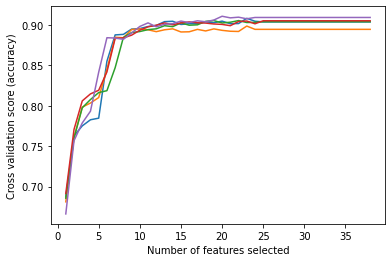

Num Features Before: 38
Num Features After: 23


In [5]:

min_features_to_select = 1

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=clf_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, step=1, min_features_to_select= min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

X_train_new = rfecv.transform(X_train)
print("Num Features Before:", X_train.shape[1])
print("Num Features After:", X_train_new.shape[1])

In [7]:
rfecv.support_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False,  True,  True,  True,
        True,  True])

In [8]:
X_train_new = X_train.iloc[:, rfecv.support_]

In [3]:
rfecv_features= ['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'G_2',
       'A_3', 'A_6', 'C_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7']

In [9]:
X_train_new.columns

Index(['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'G_2',
       'A_3', 'A_6', 'C_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7'],
      dtype='object')

In [8]:
X_train_new = X_train[rfecv_features]

In [9]:
# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a XGB model
clf_xgb = xgb.XGBClassifier(random_state=4266, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

In [10]:
clf_xgb.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4266,
              reg_alpha=0, reg_lambda=1, ...)

In [11]:

X_test_new = X_test.loc[:, rfecv_features]
X_val_new = X_val.loc[:,rfecv_features]

In [12]:
y_pred = clf_xgb.predict(X_val_new)
y_pred_proba = clf_xgb.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.966496257075041
AUC-ROC: 0.9788372735445829
PR-ROC: 0.6872393416365276


In [13]:
y_pred = clf_xgb.predict(X_test_new)
y_pred_proba = clf_xgb.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9442391393610906
AUC-ROC: 0.8658471515949618
PR-ROC: 0.4276409441283258


In [105]:
clf_xgb = gscv_model.best_estimator_

In [106]:
clf_xgb

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=4266, reg_alpha=0.5, ...)

In [107]:
clf_xgb.fit(X_train_new,y_train)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=4266, reg_alpha=0.5, ...)

In [108]:
y_pred = clf_xgb.predict(X_val_new)
y_pred_proba = clf_xgb.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9762643783092934
AUC-ROC: 0.9905874907710157
PR-ROC: 0.8131024096965662


In [109]:
y_pred = clf_xgb.predict(X_test_new)
y_pred_proba = clf_xgb.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9484273630615094
AUC-ROC: 0.8702267052120995
PR-ROC: 0.4331230185509257


In [100]:
from sklearn.model_selection import GridSearchCV


clf = xgb.XGBClassifier(random_state=4266, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "auc", objective = "binary:logistic", scale_pos_weight = scale_pos_weight, n_estimators = 200)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0, 0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

gscv_model = GridSearchCV(clf, param_grid = params, verbose =3, cv=5, scoring = 'roc_auc', n_jobs=-1)
# gscv_model.fit(X_train_new,y_train)

In [101]:
gscv_model.fit(X_train_new,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=0.8,
                                     colsample_bynode=0.8, colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=4266, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.5], 'gamma': [0.5, 1],
                         'learning_rate': [0.03, 0.05, 0.08],
                         'max_depth': [5, 7, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [300, 500, 700],
                         'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=3)

In [102]:
gscv_model.best_estimator_

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=4266, reg_alpha=0.5, ...)

In [104]:
import pickle

In [103]:
pickle.dump(gscv_model.best_estimator_,open("xgbmodelgs.pkl", "wb"))

NameError: name 'pickle' is not defined

In [27]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold, cross_val_score

In [92]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 0.1,2),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': hp.uniform('n_estimators',200,700),
#         'scale_pos_weight':scale_pos_weight,
#         'random_state': 4266,
#         #'subsample': hp.uniform('subsample',0.8,1)

#   }

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'scale_pos_weight':scale_pos_weight,
        'random_state':4266,
        'eval_metric': "auc",
        'n_estimators': hp.choice("n_estimators",[300,500,700]),
        'subsample': hp.uniform('subsample',0.8,1)

    }

In [93]:
def hyperparameter_tuning(space):
        #cale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])
        model = xgb.XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                                colsample_bytree=space['colsample_bytree'], scale_pos_weight=space['scale_pos_weight'],
                                random_state=space["random_state"],subsample=space['subsample'])
        #evaluation = [(X_train_new, y_train), (X_val_new, y_val)]
        
        
        kf = KFold(n_splits=5, random_state=4266, shuffle=True)
        # model.fit(X_train_new, y_train,
        #         eval_set=evaluation)

        score = -cross_val_score(model, X_train_new, y_train, cv=kf, scoring="roc_auc", n_jobs=-1).mean()

        # y_pred = model.predict(X_val_new)
        # y_pred_proba = model.predict_proba(X_val_new)
        # auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
        # ap = average_precision_score(y_val, y_pred_proba[:,1])
        # print("Accuracy:", accuracy_score(y_val, y_pred))
        # print("AUC-ROC:", auc_score)
        # print("PR-ROC:", ap)
        #change the metric if you like
        return {'loss': score, 'status': STATUS_OK, 'model': model}

In [94]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

print(best)

100%|██████████| 20/20 [25:44<00:00, 77.24s/trial, best loss: -0.9090348579727312] 
{'colsample_bytree': 0.9447445294123828, 'gamma': 6.992957127110471, 'max_depth': 6.0, 'min_child_weight': 7.0, 'n_estimators': 1, 'reg_alpha': 49.0, 'reg_lambda': 0.9703556258401028, 'subsample': 0.8339362347042925}


In [38]:
best = {'colsample_bytree': 0.758413048017599, 'gamma': 2.994627263462889, 'max_depth': 16, 'min_child_weight': 4.0, 'reg_alpha': 50.0, 'reg_lambda': 0.021312097813280473}

In [95]:
best = {'colsample_bytree': 0.9447445294123828, 'gamma': 6.992957127110471, 'max_depth': 6, 'min_child_weight': 7.0, 'n_estimators': 1, 'reg_alpha': 49.0, 'reg_lambda': 0.9703556258401028, 'subsample': 0.8339362347042925}

In [96]:
best_model = xgb.XGBClassifier(**best, scale_pos_weight=scale_pos_weight,random_state=4266,eval_metric="auc")

In [97]:
best_model.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9447445294123828, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc',
              gamma=6.992957127110471, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=7.0,
              missing=nan, monotone_constraints='()', n_estimators=1, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=4266,
              reg_alpha=49.0, reg_lambda=0.9703556258401028, ...)

In [98]:
y_pred = best_model.predict(X_val_new)
y_pred_proba = best_model.predict_proba(X_val_new)
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
ap = average_precision_score(y_val, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_val, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9480555048384152
AUC-ROC: 0.8717968267361791
PR-ROC: 0.34124370561798534


In [99]:
y_pred = best_model.predict(X_test_new)
y_pred_proba = best_model.predict_proba(X_test_new)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.938736963127207
AUC-ROC: 0.8099585299551144
PR-ROC: 0.31675477830821336


Save XGB Model

In [ ]:
import pickle

In [ ]:
pickle.dump(gscv_model.best_estimator_, open('xgbmodel.pkl', 'wb'))

In [113]:
clf_xgb

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=4266, reg_alpha=0.5, ...)

In [115]:
file = open("scaler.pkl","rb")

In [116]:
scaler = pickle.load(file)

In [117]:
scaler

StandardScaler()

In [120]:
data1 = pd.read_csv("dataset1.csv", index_col = 0)

In [121]:
data1

,transcript_id,transcript_pos,nucleo_seq,dwell_time_-1,sd_-1,mean_-1,dwell_time_0,sd_0,mean_0,dwell_time_1,...,G_5,T_5,A_6,C_6,G_6,T_6,A_7,C_7,G_7,T_7
0,ENST00000000233,244,AAGACCA,0.008722,3.990545,123.090909,0.010218,6.716545,125.503030,0.006773,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ENST00000000233,261,CAAACTG,0.006292,2.849892,109.027711,0.007084,3.197289,107.190964,0.007168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,ENST00000000233,316,GAAACAG,0.007237,2.782710,105.440237,0.007050,3.463964,98.539053,0.007141,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ENST00000000233,332,AGAACAT,0.010299,6.042386,129.304348,0.008195,2.733641,97.320652,0.005806,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ENST00000000233,368,AGGACAA,0.011535,6.031751,118.000000,0.012108,5.748927,121.485876,0.009484,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90805,ENST00000641784,3122,CTGACCC,0.008121,3.555862,111.063793,0.007183,6.681034,118.293103,0.005723,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
90806,ENST00000641784,3142,CTGACCC,0.009205,3.566774,105.838710,0.007797,8.440806,119.161290,0.005332,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
90807,ENST00000641784,3224,GGGACTG,0.008099,3.652063,118.746032,0.007017,4.234762,124.396825,0.006878,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
90808,ENST00000641784,3243,GGAACAA,0.008756,7.506774,122.951613,0.006466,2.713871,96.948387,0.005319,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [122]:
identity1 = data1[["transcript_id","transcript_pos"]]

In [125]:
data1_feat = data1[rfecv_features]

In [133]:
data1_feat_scaled = pd.DataFrame(scaler.transform(data1.loc[:,features]),columns=features)

In [135]:
data1_feat_scaled = data1_feat_scaled[rfecv_features]

In [130]:
features = ['dwell_time_-1',
       'sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'dwell_time_1',
       'sd_1', 'mean_1', 'pwm_score', 'A_1', 'C_1', 'G_1', 'T_1', 'A_2', 'C_2', 'G_2', 'T_2', 'A_3', 'C_3',
       'G_3', 'T_3', 'A_4', 'C_4', 'G_4', 'T_4', 'A_5', 'C_5', 'G_5', 'T_5',
       'A_6', 'C_6', 'G_6', 'T_6', 'A_7', 'C_7', 'G_7', 'T_7']

In [140]:
data1_score = clf_xgb.predict_proba(data1_feat_scaled)[:,1]

In [146]:
identity1["score"] = data1_score

<ipython-input-146-5035a5c9ac0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity1["score"] = data1_score


In [147]:
identity1

,transcript_id,transcript_pos,score
0,ENST00000000233,244,0.012419
1,ENST00000000233,261,0.013610
2,ENST00000000233,316,0.012469
3,ENST00000000233,332,0.028248
4,ENST00000000233,368,0.098201
...,...,...,...
90805,ENST00000641784,3122,0.371214
90806,ENST00000641784,3142,0.045369
90807,ENST00000641784,3224,0.699893
90808,ENST00000641784,3243,0.041363


In [148]:
identity1.to_csv("data1res.csv")

In [153]:
data2 = pd.read_csv("dataset2.csv",index_col=0)

In [155]:
identity2 = data2[['transcript_id',"transcript_pos"]]

In [156]:
identity2

,transcript_id,transcript_pos
0,tx_id_0,0
1,tx_id_0,10
2,tx_id_0,20
3,tx_id_0,30
4,tx_id_0,40
...,...,...
1318,tx_id_6,1840
1319,tx_id_6,1850
1320,tx_id_6,1860
1321,tx_id_6,1870


In [157]:
data2_feat_scaled = pd.DataFrame(scaler.transform(data2.loc[:,features]),columns=features)

In [160]:
data2_feat_scaled = data2_feat_scaled[rfecv_features]

In [161]:
data2_feat_scaled

,sd_-1,mean_-1,dwell_time_0,sd_0,mean_0,dwell_time_1,sd_1,mean_1,pwm_score,A_1,...,A_2,G_2,A_3,A_6,C_6,T_6,A_7,C_7,G_7,T_7
0,-0.824929,-0.382169,-0.048147,-0.081909,-0.798727,-0.482154,-0.689508,-0.931896,1.126966,1.456228,...,1.286957,-0.726602,1.046712,-0.775307,1.528697,-0.693718,-0.593538,-0.517113,-0.564808,1.577533
1,-0.481045,0.284657,1.142392,0.678777,0.121160,0.964201,1.136295,-2.467824,-1.025291,-0.686706,...,-0.777027,1.376269,-0.955372,-0.775307,1.528697,-0.693718,-0.593538,1.933814,-0.564808,-0.633901
2,-0.552575,0.656472,0.452057,-0.212469,0.612550,-0.154452,-0.387576,0.563450,0.342469,-0.686706,...,-0.777027,1.376269,-0.955372,-0.775307,-0.654152,1.441508,1.684813,-0.517113,-0.564808,-0.633901
3,-0.431271,0.211752,-0.632417,-0.177272,0.180908,-1.042528,0.929316,-3.030482,-0.271991,-0.686706,...,-0.777027,1.376269,-0.955372,-0.775307,1.528697,-0.693718,1.684813,-0.517113,-0.564808,-0.633901
4,-0.320673,0.768121,1.718693,0.109023,1.071655,1.263675,0.379154,1.026955,0.323239,-0.686706,...,1.286957,-0.726602,-0.955372,-0.775307,-0.654152,1.441508,1.684813,-0.517113,-0.564808,-0.633901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,1.127443,0.055959,-0.364513,-0.675936,-1.356903,-0.603908,-0.214020,-0.351212,-1.161461,-0.686706,...,-0.777027,1.376269,1.046712,-0.775307,1.528697,-0.693718,-0.593538,-0.517113,-0.564808,1.577533
1319,-0.964427,-0.442374,-0.812624,-0.729567,-1.135443,1.717939,0.501767,-0.031587,-0.666981,-0.686706,...,1.286957,-0.726602,1.046712,1.289812,-0.654152,-0.693718,-0.593538,-0.517113,1.770514,-0.633901
1320,-0.393356,0.792497,-0.327477,1.988292,0.197982,1.802522,1.793385,-1.329072,-0.631111,-0.686706,...,-0.777027,1.376269,-0.955372,1.289812,-0.654152,-0.693718,-0.593538,-0.517113,1.770514,-0.633901
1321,1.216927,-0.350520,1.786996,0.527202,0.942351,0.926445,-0.155922,-1.544568,-0.053801,-0.686706,...,1.286957,-0.726602,-0.955372,1.289812,-0.654152,-0.693718,1.684813,-0.517113,-0.564808,-0.633901


['sd_-1',
 'mean_-1',
 'dwell_time_0',
 'sd_0',
 'mean_0',
 'dwell_time_1',
 'sd_1',
 'mean_1',
 'pwm_score',
 'A_1',
 'C_1',
 'G_1',
 'T_1',
 'A_2',
 'G_2',
 'A_3',
 'A_6',
 'C_6',
 'T_6',
 'A_7',
 'C_7',
 'G_7',
 'T_7']

In [163]:
data2_score = clf_xgb.predict_proba(data2_feat_scaled)[:,1]

In [165]:
identity2["score"] = data2_score

<ipython-input-165-154681d31e26>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity2["score"] = data2_score


In [166]:
data2_score.size

1323

In [167]:
identity2

,transcript_id,transcript_pos,score
0,tx_id_0,0,0.020717
1,tx_id_0,10,0.956020
2,tx_id_0,20,0.933037
3,tx_id_0,30,0.861388
4,tx_id_0,40,0.062884
...,...,...,...
1318,tx_id_6,1840,0.040933
1319,tx_id_6,1850,0.008048
1320,tx_id_6,1860,0.141940
1321,tx_id_6,1870,0.104284


In [168]:
identity2.to_csv("data2res.csv")